In [46]:
import os, subprocess, re
import MDAnalysis as mda
from MDAnalysis.analysis import align
import numpy as np
import matplotlib.pyplot as plt

In [2]:
PATH = "combined_1EEI/"
pdb_1EE1_dir = os.listdir(PATH)

In [40]:
LIGAND_RES_THRESH = 10 # 10 angstroms from any ligand atom to nearby residue

In [41]:
def get_pocket_residues(ligand_atoms, ligand_atom_positions, protein_residues, protein_residue_coms):
    pocket_residues = set()

    for i in range(len(ligand_atoms)):
        atom = ligand_atoms[i]
        atom_xyz = ligand_atom_positions[i]

        for j, res in enumerate(protein_residues):
            if np.linalg.norm(atom_xyz - protein_residue_coms[j]) < LIGAND_RES_THRESH:
                pocket_residues.add(res)

    pocket_residues = list(pocket_residues)
    return pocket_residues

In [42]:
frame_pocket_sets = {}
frame_universes = {}

for fp in pdb_1EE1_dir:
    if "_bonds" in fp: # only look at files with CONECT bond information inside
        frame_idx = re.findall(r"\d+", fp)[1]
        pdb_fp = PATH + fp
        frame_uni = mda.Universe(pdb_fp, format="PDB")
        ligand_atoms = frame_uni.select_atoms("resname MOL")
        protein_atoms = frame_uni.select_atoms("protein")

        ligand_positions = ligand_atoms.positions

        protein_residues = protein_atoms.residues
        protein_residue_coms = [res.atoms.center_of_mass() for res in protein_atoms.residues]

        pocket_residues = get_pocket_residues(ligand_atoms, ligand_positions, protein_residues, protein_residue_coms)

        frame_pocket_sets[frame_idx] = pocket_residues
        frame_universes[frame_idx] = frame_uni

In [43]:
from pprint import pprint

pocket_sizes = []
for key, val in frame_pocket_sets.items():
    pocket_sizes.append([len(val), key])
    
max_pocket_info = max(pocket_sizes, key=lambda x : x[0])
print (max_pocket_info)

[42, '7']


In [44]:
FINAL_1EEI_POCKET_RESIDUES = frame_pocket_sets[max_pocket_info[1]]
print (FINAL_1EEI_POCKET_RESIDUES)

[<Residue SER, 133>, <Residue LEU, 134>, <Residue ALA, 135>, <Residue GLY, 136>, <Residue LYS, 137>, <Residue ARG, 138>, <Residue GLU, 11>, <Residue TYR, 12>, <Residue HIE, 13>, <Residue ASN, 14>, <Residue THR, 15>, <Residue CYX, 9>, <Residue LEU, 8>, <Residue ALA, 10>, <Residue GLU, 139>, <Residue GLN, 49>, <Residue VAL, 50>, <Residue GLU, 51>, <Residue VAL, 52>, <Residue PRO, 53>, <Residue GLY, 54>, <Residue GLN, 56>, <Residue HIE, 57>, <Residue ILE, 58>, <Residue SER, 60>, <Residue GLN, 61>, <Residue LYS, 62>, <Residue ALA, 64>, <Residue ILE, 65>, <Residue MET, 68>, <Residue CYX, 86>, <Residue VAL, 87>, <Residue TRP, 88>, <Residue ASN, 89>, <Residue ASN, 90>, <Residue LYS, 91>, <Residue THR, 92>, <Residue PRO, 93>, <Residue HIE, 94>, <Residue ALA, 95>, <Residue ILE, 96>, <Residue ALA, 97>]


In [70]:
from MDAnalysis.analysis import rms

def get_pocket_residues_rmsd(pocket_resnames, all_frame_universes_dict):
    mda_query = ""
    for res in pocket_resnames[:-1]:
        mda_query += f"(resid {res.resindex}) or "
    mda_query += f"(resid {pocket_resnames[-1].resindex})"
        
    reference_uni = all_frame_universes_dict['0'] # pick first frame
    
    for i in range(len(all_frame_universes_dict)):
        if i != 0:
            uni_to_align = all_frame_universes_dict[str(i)]
#             align.alignto(uni_to_align, reference_uni, select=mda_query, weights="mass")
            align.alignto(uni_to_align, reference_uni)
            
#     for frame_idx, frame_uni in all_frame_universes_dict.items():
        # frame_uni is a mda.Universe
#         pocket_atoms = frame_uni.select_atoms(mda_query)
#         print (frame_idx, len(pocket_atoms), len(pocket_atoms.residues), len(pocket_resnames), pocket_atoms.center_of_mass())
        
    framewise_pocket_rmsd = [(0,0) for _ in range(len(all_frame_universes_dict))]
    ref_pocket = reference_uni.select_atoms(mda_query)
    for i in range(len(all_frame_universes_dict)):
        if i != 0:
            frame_uni = all_frame_universes_dict[str(i)]
            pocket_j = frame_uni.select_atoms(mda_query)
            r = rms.rmsd(ref_pocket.positions, pocket_j.positions, superposition=True, center=True)
            framewise_pocket_rmsd[i] = (r, i)
            
    sorted_framewise_pocket_rmsd = sorted(framewise_pocket_rmsd, key=lambda x : x[0])
    
#     seen = set()
#     for f_i, frame_i_uni in all_frame_universes_dict.items():
#         for f_j, frame_j_uni in all_frame_universes_dict.items():
#             if int(f_i) != int(f_j) and (f_i, f_j) not in seen:
#                 pocket_i = frame_i_uni.select_atoms(mda_query)
#                 pocket_j = frame_j_uni.select_atoms(mda_query)
#                 r = rms.rmsd(pocket_i.positions, pocket_j.positions, superposition=True, center=True)
#                 framewise_pocket_rmsd[int(f_i)][int(f_j)] = r
#                 framewise_pocket_rmsd[int(f_j)][int(f_i)] = r
#                 seen.add((f_i, f_j))
#                 seen.add((f_j, f_i))
                
    return sorted_framewise_pocket_rmsd

In [71]:
sorted_framewise_pocket_rmsd_details = get_pocket_residues_rmsd(FINAL_1EEI_POCKET_RESIDUES, frame_universes)
sorted_framewise_pocket_rmsd_labels = [rec[1] for rec in sorted_framewise_pocket_rmsd_details]
sorted_framewise_pocket_rmsd = [rec[0] for rec in sorted_framewise_pocket_rmsd_details]

[0, 1, 2, 31, 5, 3, 30, 13, 8, 36, 26, 7, 24, 11, 23, 4, 37, 12, 33, 32, 27, 17, 28, 25, 38, 35, 14, 29, 34, 6, 9, 21, 42, 16, 39, 15, 10, 18, 40, 44, 22, 41, 43, 19, 69, 60, 20, 53, 64, 54, 57, 62, 46, 80, 77, 48, 61, 45, 58, 56, 52, 79, 47, 49, 50, 63, 67, 78, 89, 70, 65, 81, 90, 59, 51, 68, 74, 66, 94, 71, 55, 73, 75, 98, 72, 76, 84, 91, 82, 93, 99, 88, 95, 97, 92, 85, 96, 87, 83, 86]


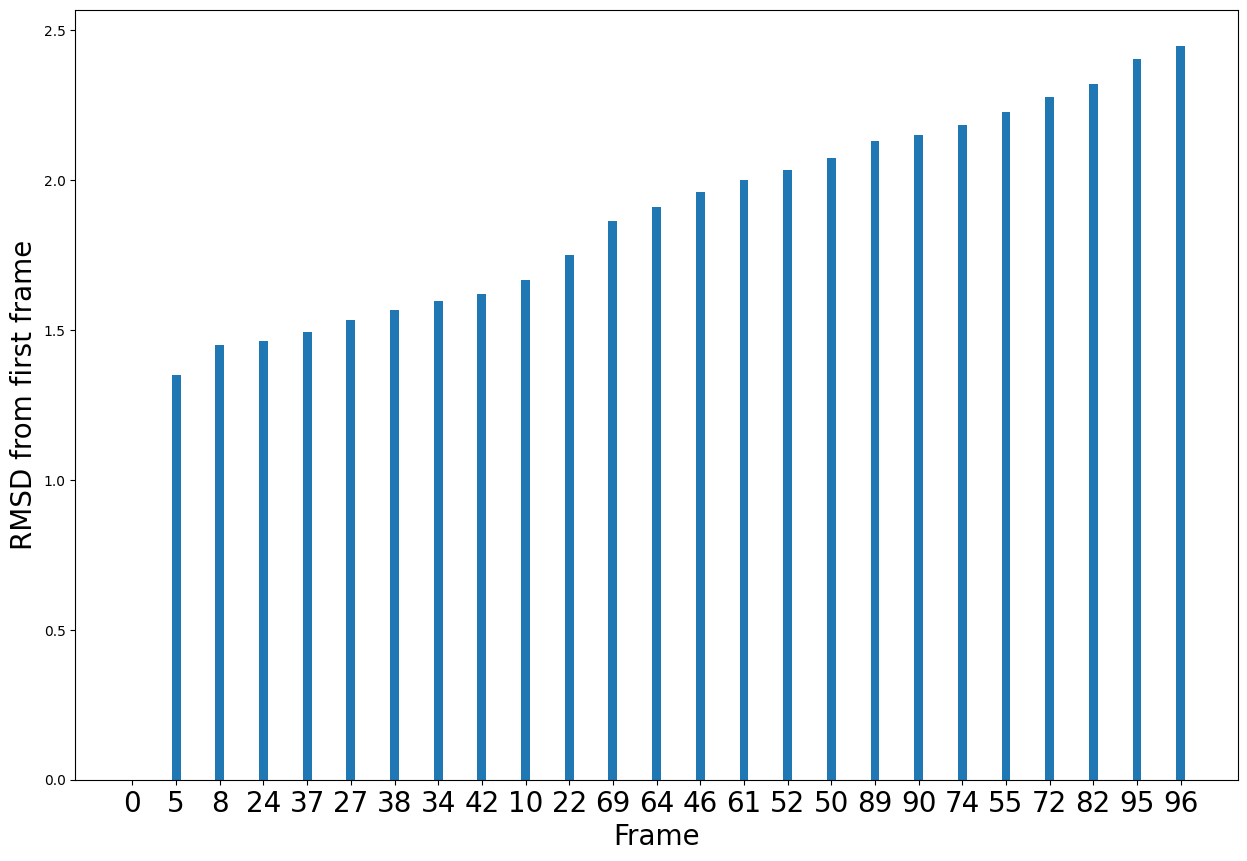

In [92]:
print (sorted_framewise_pocket_rmsd_labels)

fig = plt.figure(figsize=(15, 10))
plt.bar(height=sorted_framewise_pocket_rmsd[::4], x=range(len(sorted_framewise_pocket_rmsd_labels))[::4])
plt.xlabel("Frame", fontsize=20)
plt.ylabel("RMSD from first frame", fontsize=20)
plt.xticks(range(len(sorted_framewise_pocket_rmsd_labels))[::4], sorted_framewise_pocket_rmsd_labels[::4], size=20, )
plt.show()

In [ ]:
# each folder corresponds to the ~20 ligands generated for ONE frame

generated_ligand_path_1EEI = "1EEI_ligands/"
generated_ligand_framewise_dir_1EEI = os.listdir(generated_ligand_path_1EEI)